# Testing Stable Baselines3 with gym-MiniGrid

## Basic Jupyter Setting

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial set-up

Import libraries and classes:

In [34]:
# Imports
import time
import io
import os
import glob
import torch
import base64
# import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from random import randint 
# from stable_baselines3 import PPO, DQN, A2C
# from stable_baselines3.common.results_plotter import ts2xy, load_results
# from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
# from stable_baselines3.common.env_util import make_atari_env
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.utils import set_random_seed
# from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
# from stable_baselines3.common.env_util import make_vec_env

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Define wrapper for CNN Policy

In [35]:
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

Define the video function:

In [88]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

# video = io.open('./video/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''
#     <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
# .format(encoded.decode('ascii')))

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_animation():
    giflist = glob.glob('animation/*.gif')
    if len(giflist) > 0:
        gif_path = giflist[0]
        b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
        display.display(HTML(f'<img src="data:image/gif;base64,{b64}" height="400" />'))
    else:
        print("Could not find animation")

Define the rendering wrappers:

In [68]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

def gen_wrapped_env_cnn(env_name):
    return wrap_env(ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name))))

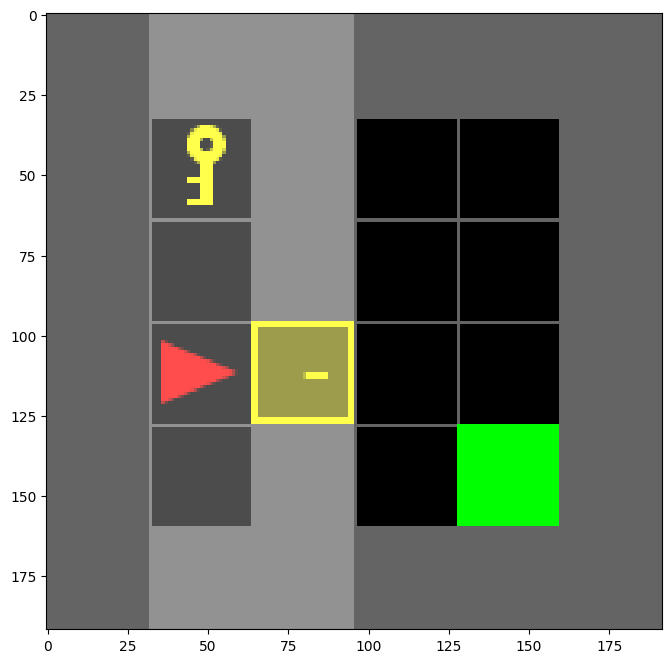

In [7]:
from random import randint
#env_id = 'MiniGrid-Empty-16x16-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
before_img = eval_env.render('rgb_array')

plt.imshow(before_img);

# Catastrophic Forgetting

## Define the environments

In [42]:
import time
import datetime
import torch
import torch_ac
import tensorboardX
import sys

import utils
from model import ACModel
from torch_ac import DictList

In [43]:
## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':'MiniGrid-Empty-5x5-v0',
'model':'MiniGrid-Empty-5x5-v0_RIM_test',
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':16,
'frames':80000, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
'lr':0.0001,
'gae_lambda':0.95, # 1 means no gae
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':False, # action = 'store_true'
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

In [44]:
# Set run dir
def reshape_reward(obs, action, reward, done):
    if not done:
        reward = -1
    else:
        reward = 1
    return reward

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-Empty-5x5-v0', 'model': 'MiniGrid-Empty-5x5-v0_RIM_test', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 80000, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0001, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': False, 'mem': True}

Device: cpu



In [45]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Load model

acmodel = ACModel(obs_space, envs[0].action_space, args.mem, args.text, args.use_rim)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): LSTMCell(64, 64)
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Optimizer loaded



In [46]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

while num_frames < args.frames:
    # Update model parameters

    update_start_time = time.time()
    exps, logs1 = algo.collect_experiences()
    logs2 = algo.update_parameters(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        data += rreturn_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

## Evaluate

In [13]:
from torch_ac.utils.penv import ParallelEnv

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'episodes':100,
'seed':1,
'procs':16,
'argmax':False,
'worst_episodes_to_show':10,
'use_rim':args.use_rim
}

args = DictList(args)

In [14]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environments

envs = []
for i in range(args.procs):
    env = utils.make_env(args.env, args.seed + 10000 * i)
    envs.append(env)
env = ParallelEnv(envs)
print("Environments loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, args.procs, args.use_rim)
print("Agent loaded\n")

# Initialize logs

logs = {"num_frames_per_episode": [], "return_per_episode": []}

Device: cpu

Environments loaded

Agent loaded



In [15]:
# Run agent

start_time = time.time()

obss = env.reset()

log_done_counter = 0
log_episode_return = torch.zeros(args.procs, device=device)
log_episode_num_frames = torch.zeros(args.procs, device=device)

while log_done_counter < args.episodes:
    actions = agent.get_actions(obss)
    obss, rewards, dones, _ = env.step(actions)
    agent.analyze_feedbacks(rewards, dones)

    log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
    log_episode_num_frames += torch.ones(args.procs, device=device)

    for i, done in enumerate(dones):
        if done:
            log_done_counter += 1
            logs["return_per_episode"].append(log_episode_return[i].item())
            logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

    mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
    log_episode_return *= mask
    log_episode_num_frames *= mask

end_time = time.time()
print("Agent run completed\n")

Agent run completed



In [16]:
# Print logs

num_frames = sum(logs["num_frames_per_episode"])
fps = num_frames/(end_time - start_time)
duration = int(end_time - start_time)
return_per_episode = utils.synthesize(logs["return_per_episode"])
num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(num_frames, fps, duration,
              *return_per_episode.values(),
              *num_frames_per_episode.values()))

# Print worst episodes

n = args.worst_episodes_to_show
if n > 0:
    print("\n{} worst episodes:".format(n))

    indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
    for i in indexes[:n]:
        print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

F 687.0 | FPS 2457 | D 0 | R:μσmM 0.94 0.02 0.85 0.95 | F:μσmM 6.9 2.0 5.0 17.0

10 worst episodes:
- episode 56: R=0.847000002861023, F=17.0
- episode 51: R=0.8740000128746033, F=14.0
- episode 42: R=0.8830000162124634, F=13.0
- episode 37: R=0.8920000195503235, F=12.0
- episode 19: R=0.9010000228881836, F=11.0
- episode 72: R=0.9010000228881836, F=11.0
- episode 82: R=0.9010000228881836, F=11.0
- episode 89: R=0.9100000262260437, F=10.0
- episode 90: R=0.9100000262260437, F=10.0
- episode 14: R=0.9190000295639038, F=9.0


## Visualization

In [100]:
import array2gif
from pathlib import Path
import numpy

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'seed':1,
'shift':0,
'argmax':False,
'pause':0.1,
'gif':args.model,
'episodes':5,
# Model Parameters
'use_rim':args.use_rim
}

args = DictList(args)

In [101]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environment

env = utils.make_env(args.env, args.seed)
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, use_rim = args.use_rim)
print("Agent loaded\n")

Device: cpu

Environment loaded

Agent loaded



In [102]:
%%capture
# Run the agent

if args.gif:
   from array2gif import write_gif
   frames = []

# Create a window to view the environment
env.render('human')

for episode in range(args.episodes):
    obs = env.reset()
    done2 = False
    while True:
        env.render('human')
        if args.gif:
            frames.append(numpy.moveaxis(env.render("rgb_array"), 2, 0))
            

        action = agent.get_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.analyze_feedback(reward, done)
        
        if done or env.window.closed:
            if episode == 4:
                done2 = True
            break
    if done2 == True:
        env.close()
        break
    #if env.window.closed:
    #    break
print('doneeee')
if args.gif:
    print("Saving gif... ", end="")
    Path("./animation").mkdir(parents=True, exist_ok=True)
    write_gif(numpy.array(frames), "./animation/"+args.gif+".gif")
    print("Done.")


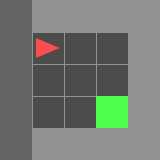

In [104]:
show_animation()

In [105]:
test_env = wrap_env(env)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
    action = agent.get_action(observation)
    observation, reward, done, info = test_env.step(action)
    episode_reward += reward
    episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.946
Total length: 6
